# ACES - Reinforcement Learning

En este Notebook se va a simular una clase de **arquitectura** y un **environment** que permitirán el entrenamiento y simulación del funcionamiento de la Edge Infrastructure del proyecto ACES.
### Arquitectura
La idea es generar un objeto de la clase **arquitectura**. Esto virtualiza el esqueleto de una Edge Infrastructure con todos los elementos necesarios para mantener el estado de la red. De esta manera, se puede interactuar con el sistema. Algunas consideraciones importantes son:
- No usamos tiempo real, usamos tiempo discreto. Siempre que se quiera simular el paso de un periodo discreto, hay que llamar a *heart_beat()*. Esto supone la adición de un periodo a las unidades de datos presentes en la arquitectura y borra las que superen la lifetime definida por el tipo de cada unidad.
- Cuando se quiera invocar un evento, {generación, llamada}, se debe llamar al método *generate(event)*. El evento puede tomar los valores {0,1,2,3,10,11,12,13}. Los valores menores a 10, invocan la generación de un tipo de datos. Ahora mismo, los tipos 0, 1 y 2, que simulan datos de monitorización, se generan en todos los dispositivos que haya en la red. El tipo 3, se genera solamente en las estaciones. Por otro lado, los eventos superiores a 10 representan llamadas a tipos de datos. Para saber el tipo de datos llamado, basta con restar 10 al evento. La llamada de estos tipos se puede hacer desde dos puntos diferentes para los tipos 1, 2 y 3, y desde un centro de datos para el tipo 3. **En caso de querer modificar los puntos de llamada de cada tipo de datos, hay que modificar el diccionario cluster que se crea en el método de inicialización.**
- Hay tres algoritmos implementados que permiten la colocación de las unidades de datos. Estos son *round_robin()*, *greedy_server()* y *greedy_algorithm()*. Se utilizan como baselines *round_robin()* y *greedy_server()*. Estos algoritmos modifican realmente el estado de la arquitectura y guardan la nueva colocación de unidades de datos.
- Finalmente, hay algunas variables y métodos que empieza por *false*. Estos métodos permiten simular la colocación de unidades de datos de algoritmos externos, en este caso el algoritmo de RL, sin modificar el estado de la arquitectura.

### Environment
Por otro lado, generamos un **environment** llamado AcesStepArchitectureEnv. En él, se presenta el environment descrito en el TFM. La idea de éste es generar una arquitectura nueva y utilizar la matriz de ejecuciones para simular el paso real del tiempo. De esta manera, en cada reset se generan 4 eventos y pasa un periodo discreto. Después, el step se ejecuta 8 veces, dos para cada tipo de datos. Sin embargo, el resultado de los steps no modifica ningún parámetro de nuestra arquitectura, que sigue su curso a pesar de las acciones realizadas por el algoritmo. El algoritmo tendrá su propio espacio libre que se actualizará en función de la colocación de las unidades de datos elegida. Así, después del entrenamiento, podremos simular una nueva arquitectura que evolucione independientemente y un algoritmo de RL que, en base al estado de la arquitectura, realice acciones. Este comportamiento permite la comparación entre el estado de la arquitectura haciendo uso o independientemente del algoritmo de RL.

In [ ]:
from gymnasium import Env                   # Clase base para la creación de Environments.
from gymnasium.spaces import Box, Dict      # Espacios utilizados en nuestro environment.
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm                       # Monitorizar el avance de los bucles.
import networkx as nx                       # Representación de grafos en Python.
from copy import copy                       # Necesario para copiar algunas estructuras por valor.
import ray                                  # Herramienta de análisis de Reinforcement Learning.
import seaborn as sns
import pandas as pd

### Clase arquitectura

Esta clase representa la Edge Infrastructure del proyecto. Se tiene que definir el número de estaciones que se quieren simular, y con su inicialización se genera una arquitectura con dos centros de datos conectados entre sí y el número de estaciones deseadas conectadas cada una con uno de los dos centros de datos. Se puede aumentar el número de centros de datos modificando la variable num_c.

Los centros de datos tienen una mayor capacidad que las estaciones. Estas medidas se pueden modificar cambiando los valores de c_capacity y s_capacity.

Por otro lado, cada unidad de datos que se halle en la arquitectura tiene un peso definido por el tipo de dato que contiene. Los pesos de las unidades de cada tipo de dato se pueden modificar cambiando el array weights.

También, el tiempo de duración de cada unidad de datos está definido por su tipo. La "caducidad" de cada tipo de datos está definida en el diccionario lifetime.

El umbral mínimo de espacio libre es un 20% la capacidad máxima de cada dispositivo. Para cambiar este porcentaje, se debe utilizar min_free_space.

In [ ]:
# Funcionamiento de la simulación de nuestra Edge Infrastructure. Es la clase que mantiene el estado y permite hacer cambios en la arquitectura digital.

# Parámetros:
#   - Num_stations (número de estaciones en la arquitectura)

class Architecture:
    def __init__(self, num_stations):
        # Capcacidad de los micro-centros de datos y de las estaciones respectivamente.
        self.c_capacity, self.s_capacity = 50, 2
        # Peso de cada uno de los tipos de dato. Posiciones correspondientes a tipo 0, 1, 2, 3.
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000]
        # Caducidad de cada tipo de dato. Posiciones correspondientes a tipo 0, 1, 2, 3.
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}
        # Longitud máxima de llamadas de tipos de dato a tener en cuenta.
        self.max_actions = 10
        # Número de micro-centros de datos en la arquitectura.
        self.num_c = 2
        # Número de estaciones en la arquitectura.
        self.num_s = num_stations
        # Mínimo porcentaje respecto a la capacidad máxima de espacio permitido en cualquier dispositivo.
        self.min_free_space = 0.2
        # Se utiliza para el greedy algorithm. Flag que indica que se ha incumplido el límite de espacio libre permitido. Si no se utiliza el greedy algorithm, saltar.
        self.space_flag = -1

        # Array que contiene los tipos de datos de cada una de las unidades de datos presentes en la arquitectura.
        self.data_types = []
        # Array que indica en qué dispositivo se sitúan las unidades de datos del array anterior (data types).
        self.data_allocation = []
        # Array que indica el tiempo que llevan presente las unidades de datos en la arquitectura.
        self.data_times = []

        # Conjunto de colecciones que se utiliza para el cálculo en paralelo de nuestras medidas de evaluación (latencia real y espacio libre de los dispositivos) del algoritmo de RL sin modificar el comportamiento de la arquitectura.
        self.false_data_types = []
        self.false_data_allocation = []
        self.false_data = {}
        self.false_devices = {}

        # Diccionario utilizado para facilitar cálculos. Contendrá una primera clave con los tipos de dato y, para cada una, una segunda clave con los dispositivos. De esta manera quedarán representados los dispositivos en los que se sitúan las unidades de cada tipo de dato.
        self.data = {}
        # Diccionario utilizado para facilitar cálculos. El inverso que el anterior. Quedarán representadas las unidades de cada tipo de dato que tiene cada dispositivo.
        self.devices = {}
        # Diccionario con dos niveles de llaves conteniendo dispositivos. Aparece la latencia que hay entre dispositivos. Hay latencias repetidas, ya que la latencia entre la estación 1 y 5 es la misma que la existente entre la estación 5 y 1, por ejemplo. Sin embargo, facilita mucho las labores de cálculo el poder utilizar indistintamente el orden de las parejas de latencias.
        self.latencies = {}
        # Se utiliza para cáculos. Es el mismo diccionario que el anterior, pero cada valor contiene la máxima latencia posible en la arquitectura.
        self.max_latencies = {}

        # Array que contiene los dispositivos desde los que se han hecho las últimas "max_actions" llamadas.
        self.action_device = []
        # Array equivalente al anterior que conteniendo los tipos de dato que se han requerido en las últimas "num_actions" llamadas.
        self.action_type = []

        # Bucle utilizado para asignar keys a los distintos diccionarios.
        for j in (range(len(self.weights))):
            self.data[j] = {}
            self.false_data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.false_data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.false_devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        # Bucle utilizado para asignar keys a los distintos diccionarios.
        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        # En este punto se establecen los distintos dispositivos desde los cuales se pueden hacer llamadas a cada dipo de datos
        devices = list(self.devices.keys())
        bound = round(len(self.devices)/4)          # Esta línea permite crear un índice que se podría utilizar para dividir los posibles dispositivos entre los 4 tipos de datos disponibles. El problema es que asigna más de dos dispositivos posibles para cada tipo de dato.
        # Creación del cluster con dos dispositivos posibles para cada tipo de datos.
        self.clusters = {
            0: devices[bound-1:bound+1],
            1: devices[2*bound-1:2*bound+1],
            2: [devices[-2], devices[3*bound-1]],
            # 3: devices[:bound]
            3: [0]
        }

        # Método que permite visualizar la arquitectura. Es importante llamarlo aunque no se quiera utilizar la representación gráfica, porque además asigna las latencias.
        self.visualization()

    # Método que construye los diccionarios de data y devices cuando se cambia allocation.
    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    # Método que construye los diccionarios de false data y false devices cuando se cambia false allocation.
    def false_construct_dictionaries(self):
        for i in self.false_data:
            for j in self.false_data[i]:
                self.false_data[i][j] = 0
        for i in self.false_devices:
            for j in self.false_devices[i]:
                self.false_devices[i][j] = 0
        for device, d_type in zip(self.false_data_allocation, self.false_data_types):
            self.false_data[d_type][device] += 1
            self.false_devices[device][d_type] += 1

    # Método llamado cada vez que se añade una nueva unidad de dato.
    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    # Método simulado para representar el paso de un periodo discreto.
    def heart_beat(self):
        deads = []

        # Se añade una unidad a la vida de cada unidad de dato y se comprueba si es igual al lifetime del tipo. De ser así, se añade a deads.
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        # En este punto se lleva a cabo la eliminación de cada tipo de dato que supera su lifetime y que, por ello, queda recogido en deads en el proceso anterior.
        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    # Cálculo del espacio libre relativo de todos los dispositivos
    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity

            # Recordemos, se utiliza para el greedy algorithm, que, por lo general, no tenemos en cuenta.
            if load[i] <= self.min_free_space:
                self.space_flag = i

        return load

    # Cálculo del falso espacio libre relativo de todos los dispositivos
    def false_free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.s_capacity

        return load

    # Método importante, no sólo permite visualizar la arquitectura, sino que también asigna los valores de las latencias
    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        # Modificar para cambiar el color de los micro-centros de datos
        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                # Modificar para cambiar el color de los micro-centros de datos
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                # Modificar el 10 para cambiar la latencia entre los micro-centros de datos
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    # Modificar para cambiar el color de las estaciones
                    colors.append('orangered')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    # Modificar el random.randint(4,6) para cambiar la latencia entre estaciones y micro-centros de datos.
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                # Modificar el 10 para cambiar la latencia entre los micro-centros de datos
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    # Modificar el random.randint(4,6) para cambiar la latencia entre estaciones y micro-centros de datos.
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    # Modificar para cambiar el color de las estaciones
                    colors.append('orangered')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # Modificar para cambiar la representación gráfica
        nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        plt.title("Architecture:")
        plt.axis('off')
        plt.show()

        # Añade las latencias al diccionario latencies
        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        # Añade la máxima latencia al diccionario max_latencies
        max_latency = max(list(self.latencies[self.num_c].values()))
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    # Cálculo de la latencia de las 10 últimas llamadas de datos con la allocation actual de unidades de datos.
    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    # Cálculo de la latencia de las 10 últimas llamadas de datos con la false allocation.
    def false_compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.false_data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    # Cálculo de la latencia NORMALIZADA de las 10 últimas llamadas de datos con la false allocation.
    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    # Cálculo de la latencia normalizada para cada tipo de datos.
    def compute_normalized_latency_dict(self):
        total_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }
        max_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }

        for key in total_latency.keys():
            for dev in range(len(self.clusters[key])):
                if self.clusters[key][dev] in self.action_device:
                    for j in self.data[key]:
                        total_latency[key] += self.latencies[self.clusters[key][dev]][j] * self.data[key][j]
                        max_latency[key] += self.data[key][j]
        for i in total_latency.keys():
            total_latency[i] = 1-total_latency[i]/(max_latency[i]*22+1)

        return total_latency

    # Genera un nuevo evento en la arquitectura, tanto adición de unidades de datos como llamadas a las mismas.
    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
        else:
            device=random.sample(self.clusters[operation-10],1)[0] if operation != 13 else self.clusters[operation-10][0]
            self.action_device.append(device)
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    # Cálculo del algoritmo de Round Robin dentro de la arquitectura
    def round_robin(self):
        allocation_round = []
        capacities = []
        for i in range(self.num_c):
            capacities.append(50)
        for i in range(self.num_s):
            capacities.append(2)
        index = 0
        server_index = 0
        for i in range(len(self.data_allocation)):
            if index == self.num_c + self.num_s:
                index = 0
            if (index != 0 or index != 1) and capacities[index] - self.weights[self.data_types[i]] <= 0.2 * 2:
                allocation_round.append(server_index)
                capacities[server_index] -= self.weights[self.data_types[i]]
                server_index = 1 if server_index == 0 else 0
            else:
                allocation_round.append(index)
                capacities[index] -= self.weights[self.data_types[i]]
                index += 1
        self.data_allocation = allocation_round.copy()
        self.construct_dictionaries()
        for i in range(80 - len(allocation_round)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_round.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_round

    # Cálculo del algoritmo Best Device
    def greedy_server(self):
        allocation_greedy= []
        index = 0
        for i in range(len(self.data_allocation)):
            allocation_greedy.append(index)
            index = 1 if index == 0 else 0
        self.data_allocation = allocation_greedy.copy()
        self.construct_dictionaries()
        for i in range(122 - len(allocation_greedy)):
            allocation_greedy.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_greedy

    # Cálculo del Greedy Algorithm. En principio, no se usa.
    def greedy_algorithm(self):
        if self.space_flag == -1:
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation.copy()
            self.construct_dictionaries()
            for i in range(122 - len(allocation)):
                allocation.append(random.randint(0,self.num_c+self.num_s-1))
            return allocation
        else:
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            return self.greedy_algorithm()

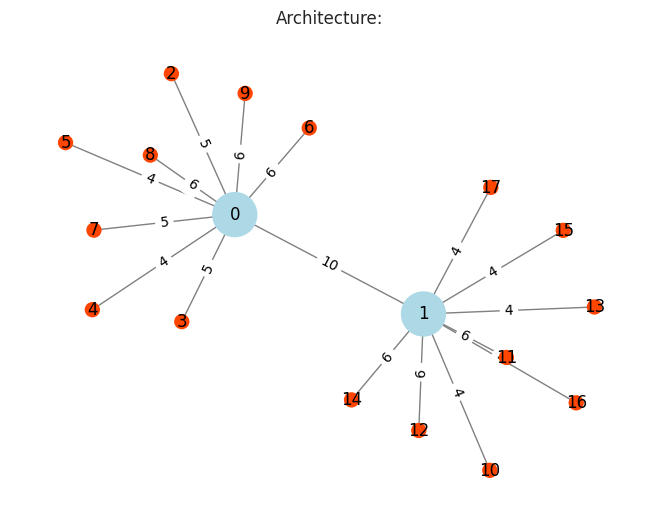

{0: [3, 4], 1: [9, 10], 2: [16, 7], 3: [0]}
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
140


In [15]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]

architecture = Architecture(16)
print(architecture.clusters)

for i in range(3):
    for j in executions:
        architecture.heart_beat()
        for h in j:
            architecture.generate(h)
print(architecture.data_allocation)
print(len(architecture.data_allocation))
# print(architecture.data)
# print(architecture.action_device)
# print(architecture.action_type)
# architecture.round_robin()
# print(architecture.compute_normalized_latency_dict())
# architecture.greedy_server()
# print(architecture.compute_normalized_latency_dict())

### Environment

##### Parámetros:
- Num_stations: Número de estaciones en la arquitectura. Es útil para conocer el factor por el que deben multiplicarse los pesos de cada unidad de datos. Puede tomar valores 6, 10 y 16. En función de este valor, cada peso se multiplicará por los siguientes enteros:
    - 6: [2,4,4,3]
    - 10: [3,6,6,5]
    - 16: [4.5,9,9,8]

In [16]:
class AcesStepArchitectureEnv(Env):
    def __init__(self, num_stations):

        #Inicializamos una nueva arquitectura.
        self.architecture = Architecture(num_stations)
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]

        #Permite saber cuál el array de executions que toca ejecutar.
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.num_stations = num_stations

        # Los multiplicadores de pesos que se utilizan en función del
        self.multipliers = {
            6: [2,4,4,3],
            10: [3,6,6,5],
            16: [4.5,9,9,8]
        }

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity]
        self.max_free_space = [self.architecture.c_capacity,self.architecture.c_capacity]

        for i in range(self.num_stations):
            self.free_space.append(self.architecture.s_capacity)
            self.max_free_space.append(self.architecture.s_capacity)

        self.last_call = [-1]
        self.weight = 0
        self.type = 0
        self.flag = False   # Sólo se utiliza para saber si es la primera o segunda ejecución del step para un mismo tipo de datos.

        # El agente sólo necesita conocer el peso de cada unidad de datos del tipo de datos a colocar, el espacio libre de cada uno de los dispositivos y las últimas llamadas de los tipos de datos.
        self.observation_space = Dict({
            "weight": Box(low=0, high=5, shape=(1,), dtype=np.float32),
            "free_space": Box(low=-50, high=50, shape=(self.num_devices,), dtype=np.float32),
            "last_calls": Box(low=-1, high=self.num_devices-1, shape=(2,), dtype=np.int32)
        })

        # La acción asigna dos dispositivos a cada tipo de datos.
        self.action_space = Box(low=0, high=self.num_devices-1, shape=(2,), dtype=np.int32)

    # Método que nos permite conocer el estado del observation space actualizado.
    def get_obs(self, type):
        # El peso de las unidades de datos se multiplica por el multiplicador correspondiente
        self.weight = self.architecture.weights[type] * self.multipliers[self.num_stations][type]

        self.flag = True if self.flag == False else False

        # Permite seleccionar los últimos dispositivos desde los que se han hecho las últimas llamadas al tipo de datos analizado.
        indices = set()
        for i in range(len(self.architecture.action_type)):
            if self.architecture.action_type[i]==type:
                indices.add(self.architecture.action_device[i])
        if len(indices) == 2:
            self.last_call = list(indices)
        elif len(indices) == 1:
            self.last_call = list(indices)
            self.last_call.append(-1)
        else:
            self.last_call = [-1,-1]

        return {
            "weight": np.array([self.weight]),
            "free_space": np.array(self.free_space),
            "last_calls": np.array(self.last_call)
        }

    def step(self,action):
        latency = 0
        alert = False # Se utiliza para saber cuándo se incumple el límite de espacio libre.
        computed_latencies = 0

        # Cálculo de la latencia y del espacio libre de cada dispositivo. Se activa alert en caso de que el espacio libre de un dispositivo sea menor que el 20% de la capacidad del mismo.
        for location in action:
            for call in self.last_call:
                if call != -1:
                    latency += self.architecture.latencies[call][location]
                    computed_latencies+=1
            self.free_space[location] -= self.weight
        for i in range(len(self.free_space)):
            if self.free_space[i] <= self.max_free_space[i]*0.2:
                alert = True

        reward = -1 if alert else 1 - (latency / (computed_latencies * 22+1))

        done = False
        info = {'type': self.type}

        # Done solo se activa cuando se pasa por segunda vez por el tipo 3. En caso de que sea la segunda vez de otro tipo, se pasa al tipo siguiente.
        if self.type == 3 and self.flag == False:
            done = True
        if self.type !=3:
            if self.flag == False:
                self.type += 1

        return self.get_obs(self.type), reward, done, info

    def reset(self):
        # En cada reset, se simula el paso de un periodo discreto, por lo que se tienen que generar los nuevos eventos y actualizar nuestro objeto de arquitectura.
        self.architecture.heart_beat()
        for execution in self.executions[self.execution_index]:
            self.architecture.generate(execution)

        # Los espacios libres de los dispositivos se inicializan a su máxima capacidad.
        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity]
        for i in range(self.num_stations):
            self.free_space.append(self.architecture.s_capacity)

        # Se hacen modificaciones varias para comenzar un nuevo episodio
        self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
        self.type = 0
        self.iter = 0
        self.flag=False
        return self.get_obs(self.type)

    def close(self):
        print('CLOSED')

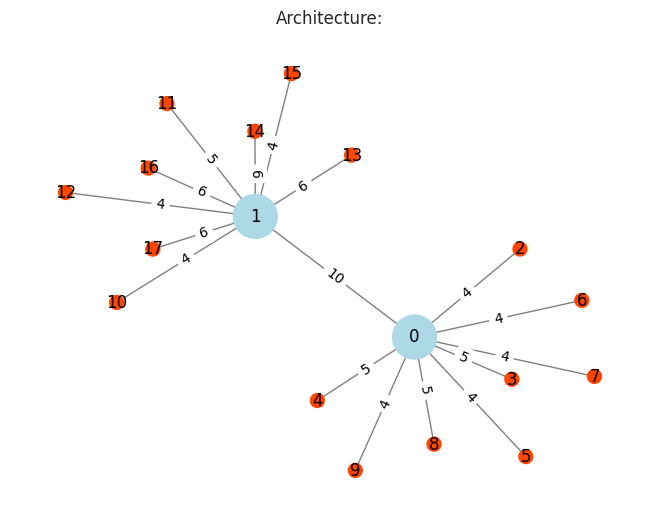

In [8]:
ar = AcesStepArchitectureEnv(16)

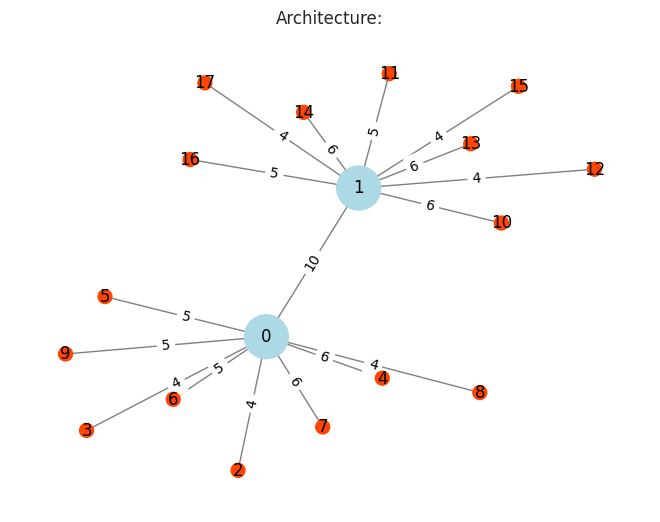

In [17]:
from ray.rllib.utils import check_env
from gymnasium.wrappers import EnvCompatibility

simulated_aces = AcesStepArchitectureEnv(16)

# Comprobación de que no hay ningún problema en la creación del environment.
check_env(EnvCompatibility(simulated_aces))

In [18]:
from ray.tune.registry import register_env
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown() # Nos aseguramos de iniciar una nueva sesión de Ray y de que no haya workers de pasadas sesiones.

# Este método permite registrar un Environment y adaptarlo al API de gymnasium. No tiene mayor importancia,
def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesStepArchitectureEnv(16)), max_episode_steps=100)

# Registramos el environment para poder llamarlo en la configuración del algoritmo de RL.
register_env("AcesStepArchitectureEnv", env_creator)

config = (
    ImpalaConfig()  # Elegimos la configuración del algoritmo deseado
        .environment("AcesStepArchitectureEnv",disable_env_checking=True)   # El environment previamente registrado y "disable_env_checking" para evitar warnings molestos.
        .rollouts(num_rollout_workers=40,   # Número de CPUs que queremos utilizar.
                  num_envs_per_worker=5)    # Número de environments que queremos que se simulen para cada agente. El máximo a partir del cual el servidor daba error es 60.
        .resources(num_gpus=0,  # Número de GPUs utilizadas
                   num_cpus_per_worker=1)   # Número de CPUs por cada worker.
        .training(entropy_coeff=0.02)   # Coeficiente de entropia elegido. Recordar que este coeficiente indica la aleatoriedad de decisiones, por lo que aumentarlo supone mayor investigación del environment por parte del agente.
    )

config["model"]["fcnet_hiddens"] = [64,64]  # Número de neuronas por cada layer de la red neuronal. Por defecto, es [64, 64]


algorithm_unified_16 = config.build()

result_unified_16 =[]

# Se entrenan el algoritmo "num_iter" veces
num_iter = 50
for j in tqdm(range(num_iter)):
    result_train = algorithm_unified_16.train()["episode_reward_mean"]
    result_unified_16.append(result_train)
    # if (j%5 == 0):
    #   print(result_train)
print(result_unified_16)

In [ ]:
# Representación gráfica de la evolución del entrenamiento
plt.plot(result_unified_16, color='darkblue')
plt.title("Evolution of training")
plt.xlabel("Iterations")
plt.ylabel("Mean reward of the episode")
plt.ylim(0, 8)
plt.xlim(0, 50)
plt.grid(False)

In [ ]:
# Creación de un nuevo environment para poder interactuar con él y ver cómo actúa el algoritmo entrenado. Se hacen 5 iteraciones para comprobar que el comportamiento del mismo no es fruto de la casualidad.

test_architecture = AcesStepArchitectureEnv(16)
latency_round_robin = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: []
}
latency_best_device = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: []
}
latency_algorithm = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: []
}
free_spaces = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: []
}
rewards = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: []
}

In [ ]:
for trial in range(5):
    for iter in range(100):
        # Nueva iteración de executions
        obs = test_architecture.reset()

        # Se llama a Round robin para ver cómo actúa
        test_architecture.architecture.round_robin()

        if iter > 10:   # Usado para limitar el almacenamiento de datos al punto en el que ya todas las unidades de datos están presentes en la arquitectura
            latency_round_robin[trial].append(test_architecture.architecture.compute_total_latency())

        # Se llama a Best device para ver cómo actúa
        test_architecture.architecture.greedy_server()
        if iter > 10:
            latency_best_device[trial].append(test_architecture.architecture.compute_total_latency())

        # A partir de aquí se funciona con el algoritmo de RL
        iteration = {}
        allocation = []
        types = []
        reward = 0

        for i in range(20):
            # El algoritmo selecciona una acción para las observaciones dadas y está acción se pasa al step.
            action = algorithm_unified_16.compute_single_action(obs)
            output = test_architecture.step(action)
            obs = output[0]

            # Se guardan las salidad del step
            reward += output[1]
            type = output[3]['type']
            iteration[i] = output[1]

            # Se adaptan las salidas para cada tipo de datos al número de elementos que debe haber presente en la arquitectura
            if type==0:
                for j in range(4):
                    for k in range(2):
                        allocation.append(action[k])
                        types.append(0)
                    if len(allocation) == 16:
                        for k in range(2):
                            allocation.append(action[k])
                            types.append(0)
            elif type==1:
                for j in range(9):
                    for k in range(2):
                        allocation.append(action[k])
                        types.append(1)
            elif type==2:
                for j in range(9):
                    for k in range(2):
                        allocation.append(action[k])
                        types.append(2)
            else:
                for j in range(8):
                    for k in range(2):
                        if output[1] != -1:
                            allocation.append(action[k])
                            types.append(3)
                        else:
                            allocation.append(random.randint(0,1))
                            types.append(3)
            if output[2]:
                break

        # Se actualizan los elementos false de la arquitectura que permiten el cálculo de latencias y espacio libre resultante del algoritmo sin modificar el funcionamiento de la arquitectura.
        test_architecture.architecture.false_data_allocation = allocation
        test_architecture.architecture.false_data_types = types
        test_architecture.architecture.false_construct_dictionaries()

        # Se almacenan los resultados de latencia, espacio libre y reward del episodio
        if iter > 10:
            latency_algorithm[trial].append(test_architecture.architecture.false_compute_total_latency())
            free_spaces[trial].append(test_architecture.architecture.false_free_space())
            rewards[trial].append(reward)

In [ ]:
plt.plot(latency_round_robin[1], color='darkblue', label = "Round-robin")
plt.plot(latency_best_device[1], color='orangered', label = "Best device")
plt.plot(latency_algorithm[1], color='black', label = "RL algorithm")
plt.title("Comparison of latencies for sixteen stations")
plt.xlabel("Iterations")
plt.ylabel("Latencies")
plt.legend()
plt.grid(False)
plt.ylim(0, 4500)
plt.xlim(0, 99)

In [ ]:
pip freeze > requirements.txt   # Genera el fichero requirements.txt en el servidor, así que hay que copiarlo al proyecto. Lo hice de manera manual por sencillez y porque no esperaba repetir la operación, pero seguro que se puede automatizar.